# Forest Cover Type Prediction

## Traitement des données

### Télécharement des données

Les données https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data seront téléchargées à l'adresse *'./covtype/archives/'*

In [35]:
from urllib.request import urlopen
import os.path as osp
import os
import logging
import gzip
logging.getLogger().setLevel('INFO')

### Variables

In [36]:
import pandas as pd
import numpy as np

In [37]:
# dict_attributs : dictionnaire qui associe les attributs aux bons index
dict_attributs = {'Elevation':[0],'Aspect':[1],'Slope':[2],
                  'Horizontal_Distance_To_Hydrology':[3],
                  'Vertical_Distance_To_Hydrology':[4],
                  'Horizontal_Distance_To_Roadways':[5],
                  'Hillshade_9am':[6],'Hillshade_Noon':[7],
                  'Hillshade_3pm':[8],
                  'Horiontal_Distance_To_Fire_Points':[9],
                  'Wilderness_Area':[10,11,12,13],
                  'Soil_Type':list(range(14,54)),
                  'Cover_Type':[54]}

# forest_cover_types :
#  1 : Spruce/Fir
#  2 : Lodgepole Pine
#  3 : Ponderosa Pine
#  4 : Cottonwood/Willow
#  5 : Aspen
#  6 : Douglas-fir
#  7 : Krummholz
forest_cover_types = ['','Spruce/Fir','Lodgepole Pine','Ponderosa Pine',
                      'Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']

# qualitative : attributs des données qualitatives
qualitative = ['Cover_Type','Wilderness_Area','Soil_Type']

def convert_to_listofbool(df_attribut):
    return [list(map(int,X.split())) for X in df_attribut]

def convert_to_int(df_attribut):
    return list(map(int,df_attribut))

def convert_to_float(df_attribut):
    return list(map(float,df_attribut))

In [38]:
# df_covtype : DataFrame de toutes les données non traitées triées par attribut
df_covtype = pd.read_csv('covtype/archives/covtype.data.gz',
                         header=None,
                         parse_dates=dict_attributs,
                         compression='gzip')

# wilderness et soil : gardent en mémoire les vecteurs binaires pour les remplacer par des entiers
# Wilderness_Areas
#  1 : Rawah Wilderness Area
#  2 : Neota Wilderness Area
#  3 : Comanche Peak Wilderness Area
#  4 : Cache la Poudre Wilderness Area
# Soil_Types
#  1 to 40 : based on the USFS Ecological Landtype Units for this study area.
for attribut in dict_attributs:
    if attribut is 'Wilderness_Area':
        wilderness = convert_to_listofbool(df_covtype[attribut])
        df_covtype[attribut] = [x.index(1)+1 for x in wilderness]

    elif attribut is 'Soil_Type':
        soil = convert_to_listofbool(df_covtype[attribut])
        df_covtype[attribut] = [x.index(1)+1 for x in soil]

    elif attribut in ['Cover_Type','Hillshade_9am','Hillshade_Noon','Hillshade_3pm']:
        df_covtype[attribut] = convert_to_int(df_covtype[attribut])

    else:
        df_covtype[attribut] = convert_to_float(df_covtype[attribut])

# labels : array des étiquettes des types de forêts
labels = np.unique(df_covtype.Cover_Type.values)

In [45]:
df_covtype.head()

,Horiontal_Distance_To_Fire_Points,Soil_Type,Hillshade_9am,Slope,Aspect,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Cover_Type,Wilderness_Area,Horizontal_Distance_To_Roadways,Elevation,Hillshade_3pm,Hillshade_Noon
0,6279.0,29,221,3.0,51.0,0.0,258.0,5,1,510.0,2596.0,148,232
1,6225.0,29,220,2.0,56.0,-6.0,212.0,5,1,390.0,2590.0,151,235
2,6121.0,12,234,9.0,139.0,65.0,268.0,2,1,3180.0,2804.0,135,238
3,6211.0,30,238,18.0,155.0,118.0,242.0,2,1,3090.0,2785.0,122,238
4,6172.0,29,220,2.0,45.0,-1.0,153.0,5,1,391.0,2595.0,150,234


## Analyse préliminaire et pré-traitement des données 

In [40]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

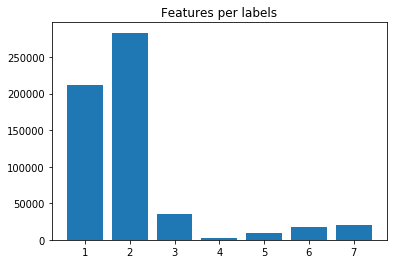

In [41]:
# df_bycovtype : DataFrame.groupby de toutes les données triées par attributs et regroupée par classes. 
df_bycovtype = df_covtype.groupby('Cover_Type')

nb_per_labels=df_bycovtype.size()
plt.bar(labels,nb_per_labels.values)
plt.title('Features per labels')
plt.show()

### Visualisation des données

In [47]:
df_bycovtype[['Elevation','Slope','Aspect','Soil_Type','Wilderness_Area']].mean()

,Elevation,Slope,Aspect,Soil_Type,Wilderness_Area
Cover_Type,,,,,
1,3128.644888,13.127110,156.138227,27.749514,1.914138
2,2920.936061,13.550499,152.060515,24.351732,1.946869
3,2394.509845,20.770208,176.372490,6.285618,3.600045
4,2223.939934,18.528941,137.139425,7.028031,4.000000
5,2787.417571,16.641315,139.283051,21.696303,2.203413
6,2419.181897,19.048886,180.539068,10.174814,3.560891
7,3361.928669,14.255924,153.236226,36.608191,2.390249


In [46]:
df_bycovtype[['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']].mean()

,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
Cover_Type,,,
1,211.998782,223.430211,143.875038
2,213.844423,225.326596,142.983466
3,201.918415,215.826537,140.367176
4,228.345832,216.997088,111.392792
5,223.474876,219.035816,121.920889
6,192.844302,209.827662,148.284044
7,216.967723,221.746026,134.932033


In [67]:
df_bycovtype[['Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Hydrology',
              'Horiontal_Distance_To_Fire_Points','Horizontal_Distance_To_Roadways']].mean()

,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Horiontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways
Cover_Type,,,,
1,42.156939,270.555245,2009.253517,2614.834517
2,45.884219,279.916442,2168.154849,2429.530799
3,62.446915,210.276473,910.955949,943.940734
4,41.186749,106.934838,859.124135,914.199490
5,50.610344,212.354893,1577.719794,1349.765722
6,45.437439,159.853458,1055.351471,1037.169805
7,69.474305,356.994686,2070.031594,2738.250463


On regarde d'abord les valeurs moyennes de chaque attribut, par classe, pour observer une première fois les attributs les plus importants.

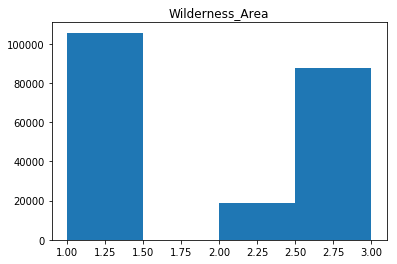

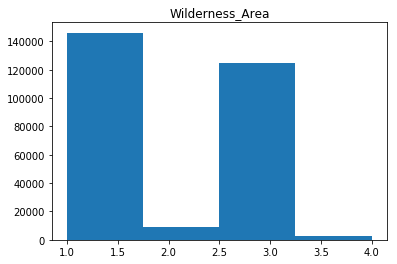

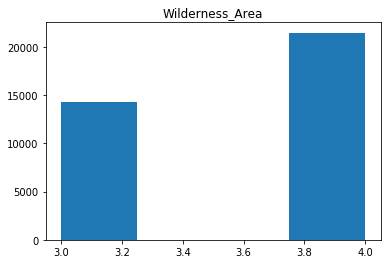

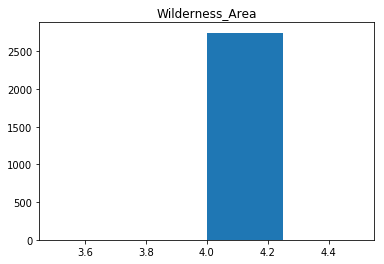

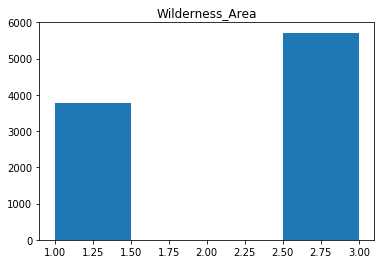

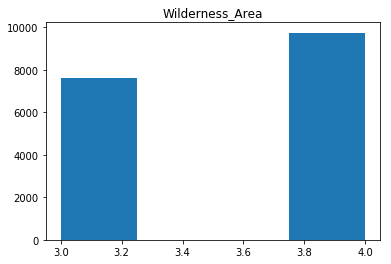

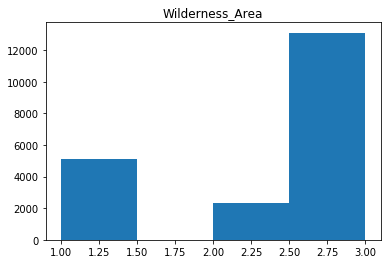

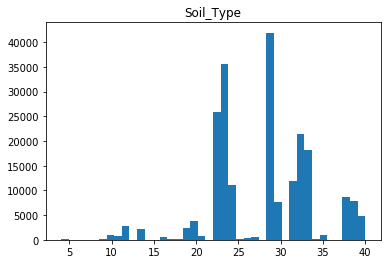

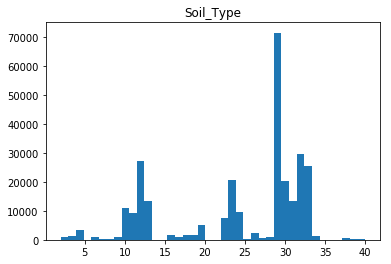

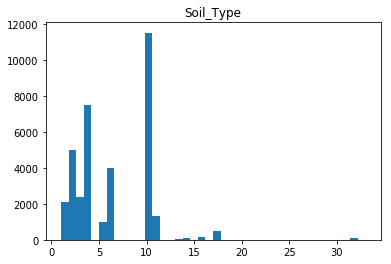

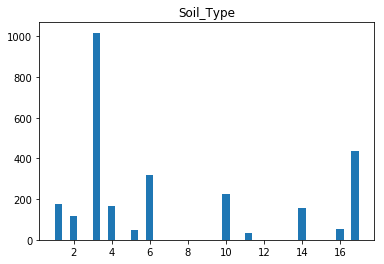

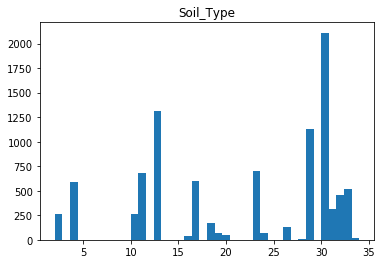

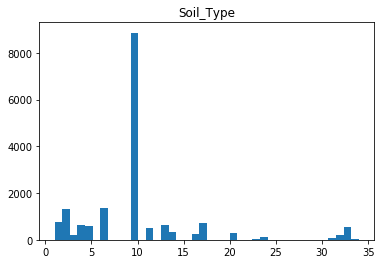

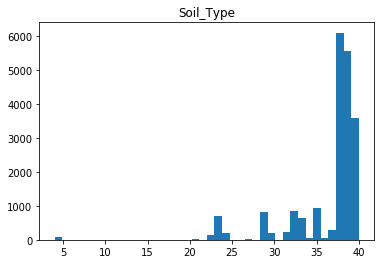

In [69]:
for attribut in ['Wilderness_Area','Soil_Type']:
    attribut_labels = df_covtype[attribut].values
    df_bycovtype.hist(column=attribut,bins=max(attribut_labels),grid=False)
    plt.show()

On voit que les distributions des deux données qualitatives sont importantes, nous allons donc les garder, malgré le fait que nous ayons 54 paramètres au lieu de 10.

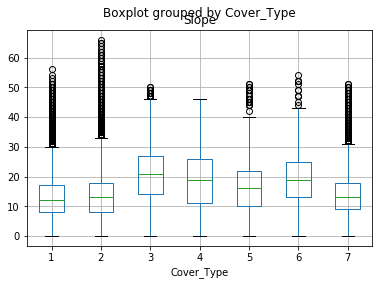

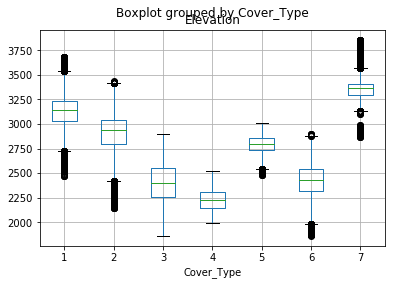

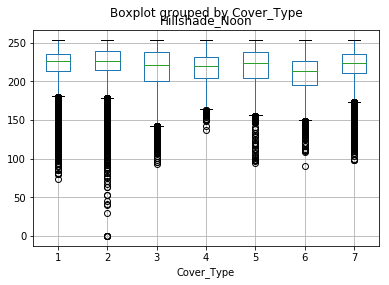

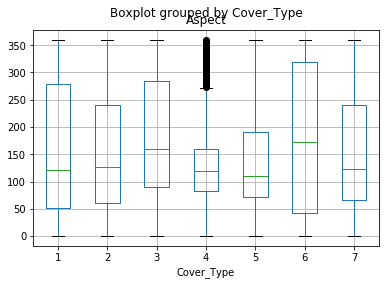

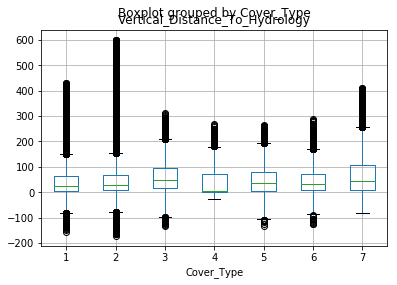

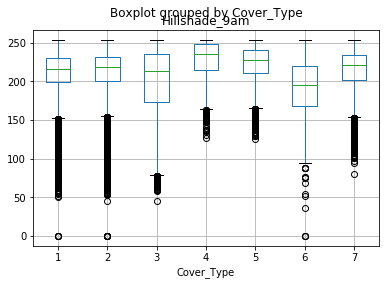

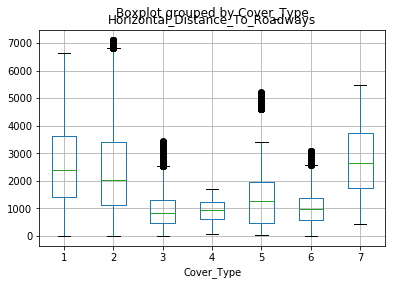

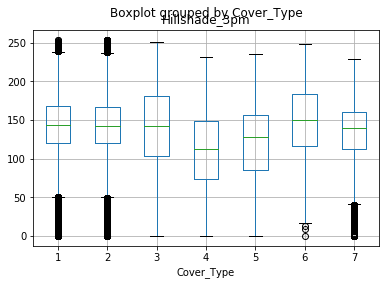

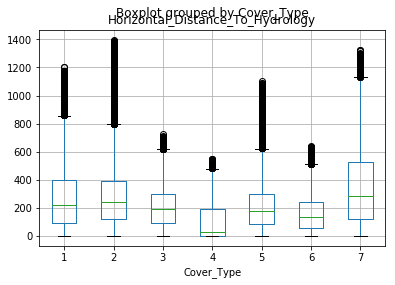

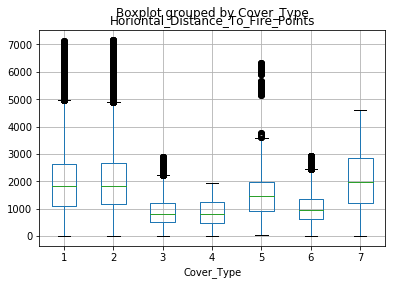

In [10]:
for attribut in dict_attributs:
    if not(attribut in qualitative):
        df_covtype.boxplot(column=attribut,by='Cover_Type')
        plt.show()

Ici on voit que les données sur l'ombre au solstice ne varient pas beaucoup selon les types de forêts. Nous chercherons

In [170]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

def scatter(keys,volume=False):
    if not(volume):
        sm = scatter_matrix(df_covtype[keys][:500],c=df_covtype.Cover_Type.values[:500])

        #Change label rotation
        [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
        [s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]

        #May need to offset label when rotating to prevent overlap of figure
        [s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

        #Hide all ticks
        [s.set_xticks(()) for s in sm.reshape(-1)]
        [s.set_yticks(()) for s in sm.reshape(-1)]
        plt.show()
    else: #plot3d by class
        plotly.tools.set_credentials_file(username='kevinzagalo', api_key='tZ4DZDjSf7SjDoNZUZjV')

        data=[]
        cov = df_covtype['Cover_Type'].values

        for n, color in zip(range(1,8),['blue','red','green','orange','pink','yellow','purple']):

            xs = df_covtype[keys[0]][cov==n].values[:500]
            ys = df_covtype[keys[1]][cov==n].values[:500]
            zs = df_covtype[keys[2]][cov==n].values[:500]

            trace = go.Scatter3d(
                x=xs,
                y=ys,
                z=zs,
                mode='markers',
                marker=dict(
                    size=12,
                    line=dict(
                        color=color,
                        width=0.5
                    ),
                    opacity=0.8
                )
            )
            data.append(trace)
        layout = go.Layout(
                    margin=dict(
                        l=0,
                        r=0,
                        b=0,
                        t=0
                    )
                )
        return data,layout

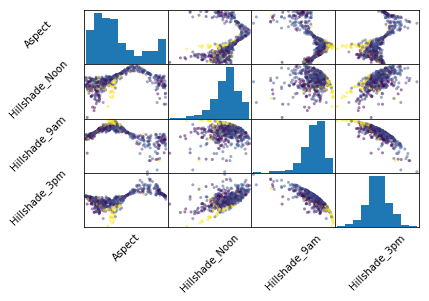

In [171]:
scatter(['Aspect','Hillshade_Noon','Hillshade_9am','Hillshade_3pm'])

On peut voir que les données sont corrélées. On peut potentiellement réduire le nombre d'attributs.

In [175]:
data,layout = scatter(['Hillshade_Noon','Hillshade_9am','Hillshade_3pm'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='hillshade-scatter')

In [176]:
data,layout = scatter(['Aspect','Elevation','Slope'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='aspect-scatter')

Au vu de la ressemblance des deux nuages de points, on peut se permettre de condenser ces deux variables en une seule.

In [178]:
data,layout = scatter(['Distance_To_Hydrology','Elevation','Horizontal_Distance_To_Roadways'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='elevation-scatter')

### Normalisation et ajout/suppression de données

On introduit un nouvel attribut qui en remplacera une paire :
$$ \verb!Distance_To_Hydrology! = \sqrt{\verb!Vertical_Distance_To_Hydrology!^2 + \verb!Horizontal_Distance_To_Hydrology!^2}$$

In [64]:
def dist(x,y):
    return np.sqrt(np.array(x)**2 + np.array(y)**2)

df_covtype['Distance_To_Hydrology'] = dist(df_covtype.Vertical_Distance_To_Hydrology.values,
                                           df_covtype.Horizontal_Distance_To_Hydrology.values)

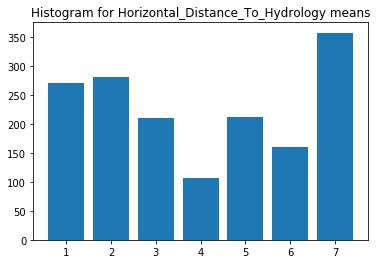

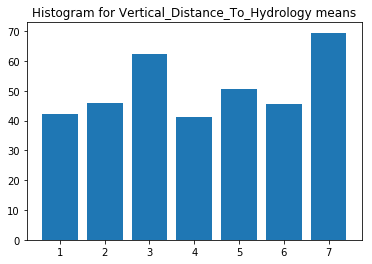

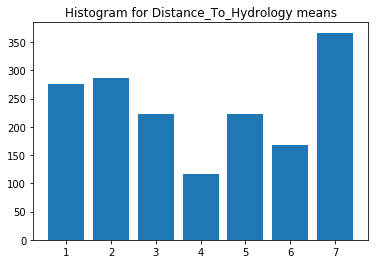

In [81]:
for attribut in ['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Distance_To_Hydrology']:
    plt.bar(labels,df_bycovtype[attribut].mean())
    plt.title('Histogram for ' + attribut + ' means')
    plt.show()

In [15]:
# On sépare les labels et les données qualitatives des features,puis on supprime les colonneres inutiles
df_covtype = df_covtype.drop(['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology'],axis=1)
data0 = df_covtype.drop(qualitative,axis=1).values
target = df_covtype.Cover_Type.values

N,d = data0.shape
data = np.zeros((N,d+len(wilderness[0])+len(soil[0])))

# Normalisation
for i in range(d):
    data[:,i] = data0[:,i]/sum(data0[:,i])
    
# On remet les données qualitative de sorte à pouvoir les exploiter
for n in range(N):
    deleted_data = np.concatenate([wilderness[n],soil[n]])
    data[n] = np.concatenate([data0[n],deleted_data])

In [86]:
len(soil[0])

40

### Données de train/validation/test

Pour l'instant on laisse les variables Wilderness_Area et Soil_Type de côté. On cherchera à savoir ensuite si les 54 attributs sont necessaires ou si les 10 premiers sont suffisants.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Ensemble de train et ensemble de test
(x_train,x_test,y_train,y_test) = train_test_split(data,target,
                                                   random_state=0,
                                                   test_size=.25)

# Ensemble de validation 
(x_train,x_valid,y_train,y_valid) = train_test_split(x_train,
                                                     y_train,
                                                     test_size=.1)

# Résumé
print("x_train shape:", x_train.shape, 
      "y_train shape:", y_train.shape)
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (392183, 54) y_train shape: (392183,)
392183 train set
43576 validation set
145253 test set


## Test de différents modèles

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [61]:
names = ["Nearest Neighbors","Random Forest","Neural Net","QDA","SVM"]

classifiers = [KNeighborsClassifier(1),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               MLPClassifier(alpha=1000,verbose=1),
               QDA(),
               SVC(gamma=.02,C=1000)]
               
def summarize(clf,x_train,y_train,x_valid,y_valid):
    clf.fit(x_train,y_train)
    predicted = clf.predict(x_valid)
    
    print('\n Matrice de confusion :\n',confusion_matrix(y_valid,predicted),'\n')
    print('\n Rapport :\n',classification_report(y_valid,predicted))

    # Evaluate the model on test set
    score = clf.score(x_valid, y_valid)

    # Print test accuracy
    print('\n Test accuracy:', score)

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
for name, clf in zip(names, classifiers):
    print(name,'\n--------------------')
    summarize(clf,x_train,y_train,x_valid,y_valid)

INFO:root:training...


Nearest Neighbors 
--------------------


INFO:root:predicting...


Matrice de confusion :
 [[15364   565     2     0     8     0    52]
 [  494 20476    29     0    67    28     5]
 [    0    31  2575    16     8    40     0]
 [    0     0    19   169     0     9     0]
 [   13    58     8     0   661     4     0]
 [    1    27    41     5     1  1230     0]
 [   52     8     0     0     0     0  1510]] 

             precision    recall  f1-score   support

          1       0.96      0.96      0.96     15991
          2       0.97      0.97      0.97     21099
          3       0.96      0.96      0.96      2670
          4       0.89      0.86      0.87       197
          5       0.89      0.89      0.89       744
          6       0.94      0.94      0.94      1305
          7       0.96      0.96      0.96      1570

avg / total       0.96      0.96      0.96     43576



INFO:root:training...



 Test accuracy: 0.9634890765559023
Random Forest 
--------------------


INFO:root:predicting...
/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
INFO:root:training...


Matrice de confusion :
 [[ 2419 13572     0     0     0     0     0]
 [  484 20570    45     0     0     0     0]
 [    0  2213   457     0     0     0     0]
 [    0   197     0     0     0     0     0]
 [    0   744     0     0     0     0     0]
 [    0  1137   168     0     0     0     0]
 [  537  1033     0     0     0     0     0]] 

             precision    recall  f1-score   support

          1       0.70      0.15      0.25     15991
          2       0.52      0.97      0.68     21099
          3       0.68      0.17      0.27      2670
          4       0.00      0.00      0.00       197
          5       0.00      0.00      0.00       744
          6       0.00      0.00      0.00      1305
          7       0.00      0.00      0.00      1570

avg / total       0.55      0.54      0.44     43576


 Test accuracy: 0.5380484670460804
Neural Net 
--------------------
Iteration 1, loss = 24.34232927
Iteration 2, loss = 8.74113189
Iteration 3, loss = 5.69893284
Iteration 4, lo

INFO:root:predicting...


Iteration 91, loss = 0.88889988
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Matrice de confusion :
 [[11897  4094     0     0     0     0     0]
 [ 4888 16107   104     0     0     0     0]
 [    0  1128  1542     0     0     0     0]
 [    0     9   188     0     0     0     0]
 [    0   744     0     0     0     0     0]
 [    0   623   682     0     0     0     0]
 [ 1561     9     0     0     0     0     0]] 



INFO:root:training...


             precision    recall  f1-score   support

          1       0.65      0.74      0.69     15991
          2       0.71      0.76      0.74     21099
          3       0.61      0.58      0.59      2670
          4       0.00      0.00      0.00       197
          5       0.00      0.00      0.00       744
          6       0.00      0.00      0.00      1305
          7       0.00      0.00      0.00      1570

avg / total       0.62      0.68      0.65     43576


 Test accuracy: 0.6780337800624197
QDA 
--------------------


/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
INFO:root:predicting...


Matrice de confusion :
 [[  316    30  1662     0  7679  1606  4698]
 [ 2090    94  3886   230 11374  2132  1293]
 [    0     0  1072  1597     0     1     0]
 [    0     0     0   197     0     0     0]
 [    0     0   238     0   450    56     0]
 [    0     0   456   720    11   118     0]
 [    3     0    72     0   112    18  1365]] 

             precision    recall  f1-score   support

          1       0.13      0.02      0.03     15991
          2       0.76      0.00      0.01     21099
          3       0.15      0.40      0.21      2670
          4       0.07      1.00      0.13       197
          5       0.02      0.60      0.04       744
          6       0.03      0.09      0.05      1305
          7       0.19      0.87      0.31      1570

avg / total       0.43      0.08      0.04     43576



INFO:root:training...



 Test accuracy: 0.08288966403524876
SVM 
--------------------


### k-plus proches voisins

In [ ]:
clf = KNeighborsClassifier(3)
clf.fit(x_train,y_train)
predicted = clf.predict(x_valid)
    
print('\n-----------------------------\n' 
          + "Nearest Neighbors : "
          + "k = 3"
          + '\n-----------------------------\n')
print('Matrice de confusion :\n', confusion_matrix(y_valid,predicted),'\n')
print('Rapport : \n', classification_report(y_valid,predicted))

# Evaluate the model on test set
score = clf.score(x_valid, y_valid)

# Print test accuracy
print('\n Test accuracy:', score)

### Support Vector Machine

In [ ]:
clf = SVC(gamma=.02,C=8500)

clf.fit(x_train,y_train)
predicted = clf.predict(x_valid)
    
print('----------------------\n SVM \n----------------------')
print('Matrice de confusion :\n',confusion_matrix(y_valid,predicted),'\n')
print(classification_report(y_valid,predicted))

# Evaluate the model on test set
score = clf.score(x_valid, y_valid)

# Print test accuracy
print('\n', 'Test accuracy:', score)

In [24]:
clf = Dense(7, activation='softmax')
clf.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

AttributeError: 'Dense' object has no attribute 'compile'

In [ ]:
clf.fit(x_train,y_train)
predicted = clf.predict(x_valid)
    
print('----------------------\n SVM \n----------------------')
print('Matrice de confusion :\n',confusion_matrix(y_valid,predicted),'\n')
print(classification_report(y_valid,predicted))

# Evaluate the model on test set
score = clf.score(x_valid, y_valid)

# Print test accuracy
print('\n', 'Test accuracy:', score)